# T6 - Using analyzers

Analyzers are objects that do not change the behavior of a simulation, but just report on its internal state, almost always something to do with `sim.people`. This tutorial takes you through some of the built-in analyzers and gives a brief example of how to build your own.

## Age histograms and snapshots

Age histograms and snapshots both take "pictures" of the `sim.people` object at specified points in time. This is because while most of the information from `sim.people` is retrievable at the end of the sim from the stored events, it's much easier to see what's going on at the time. While the snapshot literally just makes a copy of the people object, the age histogram calculates results for different age bins:

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


[<Figure size 1200x800 with 4 Axes>]

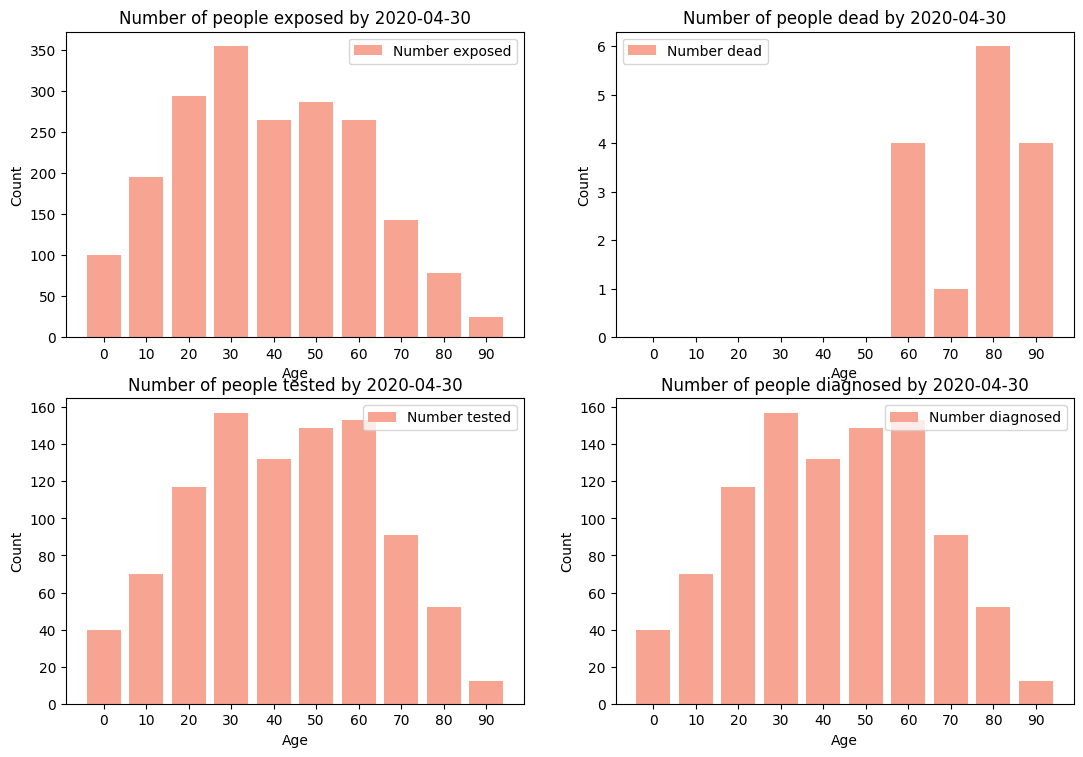

In [1]:
import covasim as cv
cv.options.set(dpi=100, show=False, close=True, verbose=0) # Standard options for Jupyter notebook

sim = cv.Sim(interventions=cv.test_prob(0.5), analyzers=cv.age_histogram())
sim.run()
agehist = sim.get_analyzer() # Only one analyzer so we can retrieve it like this
agehist.plot()

## Transmission trees

Another useful analysis to perform on the simulation is to calculate the *transmission tree* – i.e., who infected whom. Since all this information is stored in the sim, it doesn't have to be inserted at run time; it can be added to an already finished simulation:

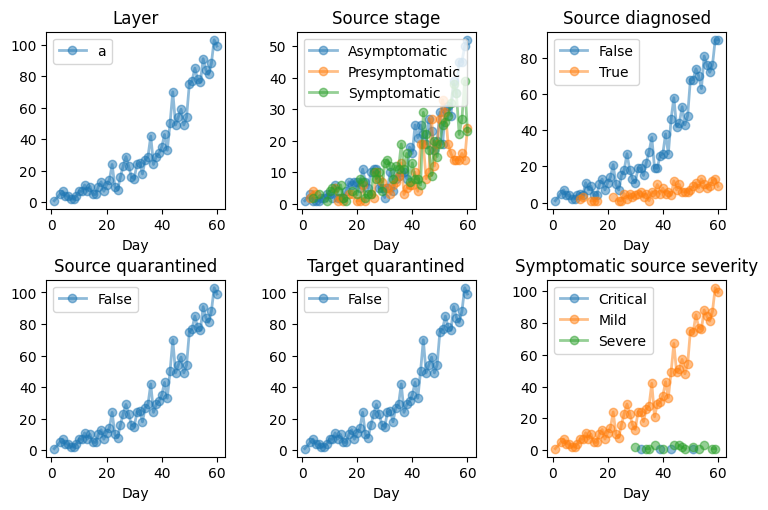

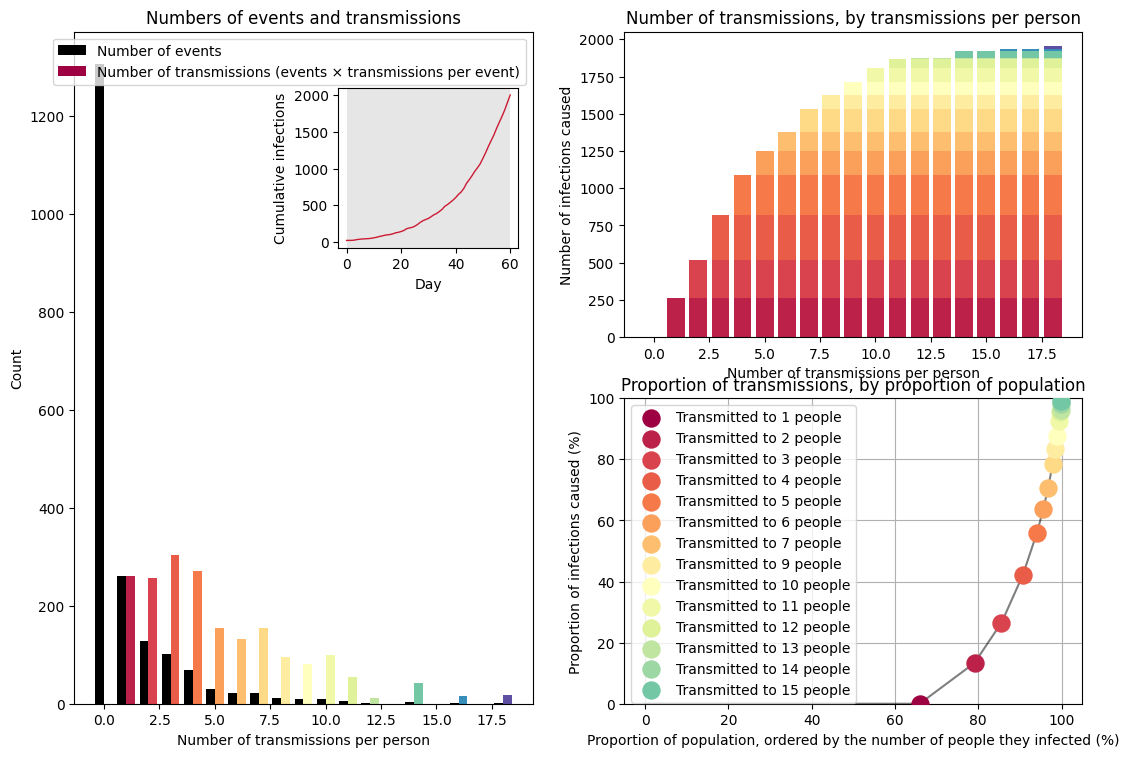

In [2]:
tt = sim.make_transtree()
fig1 = tt.plot()
fig2 = tt.plot_histograms()

## Custom analyzers

Analyzers don't have to be complicated. While analyzers can derive from the `cv.Analyzer` class, they can also just be simple functions, unless they need to keep track of or update internal state. Here's an example of an analyzer that does keep track of internal state, namely by storing and plotting the S, E, I, and R compartments over time.

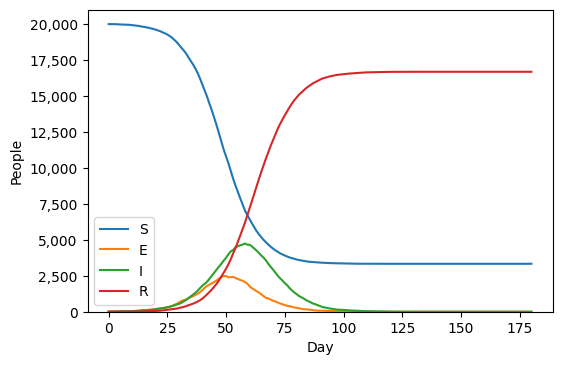

In [3]:
import pylab as pl
import sciris as sc
import covasim as cv

class store_seir(cv.Analyzer):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs) # This is necessary to initialize the class properly
        self.t = []
        self.S = []
        self.E = []
        self.I = []
        self.R = []
        return

    def apply(self, sim):
        ppl = sim.people # Shorthand
        self.t.append(sim.t)
        self.S.append(ppl.susceptible.sum())
        self.E.append(ppl.exposed.sum() - ppl.infectious.sum())
        self.I.append(ppl.infectious.sum())
        self.R.append(ppl.recovered.sum() + ppl.dead.sum())
        return

    def plot(self):
        pl.figure()
        pl.plot(self.t, self.S, label='S')
        pl.plot(self.t, self.E, label='E')
        pl.plot(self.t, self.I, label='I')
        pl.plot(self.t, self.R, label='R')
        pl.legend()
        pl.xlabel('Day')
        pl.ylabel('People')
        sc.setylim() # Reset y-axis to start at 0
        sc.commaticks() # Use commas in the y-axis labels
        return

sim = cv.Sim(n_days=180, analyzers=store_seir(label='seir'))
sim.run()
seir = sim.get_analyzer('seir') # Retrieve by label
seir.plot()

And here's an example of an analyzer that doesn't need any internal state, so it can just be a function: it simply reports if anyone aged 88 is currently infected.

In [4]:
def check_88(sim):
    people_who_are_88 = sim.people.age.round() == 88 # Find everyone who's aged 88 (to the nearest year)
    people_exposed = sim.people.exposed # Find everyone who's infected with COVID
    people_who_are_88_with_covid = cv.true(people_who_are_88 * people_exposed) # Multiplication is the same as logical "and"
    n = len(people_who_are_88_with_covid) # Count how many people there are
    if n:
        print(f'Oh no! {n} people aged 88 have covid on timestep {sim.t} {"🤯"*n}')
    return

sim = cv.Sim(n_days=120, analyzers=check_88, verbose=0)
sim.run()

Oh no! 1 people aged 88 have covid on timestep 10 🤯
Oh no! 1 people aged 88 have covid on timestep 11 🤯
Oh no! 1 people aged 88 have covid on timestep 12 🤯
Oh no! 2 people aged 88 have covid on timestep 13 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 14 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 15 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 16 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 17 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 18 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 19 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 20 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 21 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 22 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 23 🤯🤯
Oh no! 2 people aged 88 have covid on timestep 24 🤯🤯
Oh no! 1 people aged 88 have covid on timestep 27 🤯
Oh no! 3 people aged 88 have covid on timestep 28 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 29 🤯🤯🤯
Oh no! 3 people aged 88 have covid on timestep 3